<a href="https://colab.research.google.com/github/rashidkisejjere0784/course-guidance-ML-model/blob/main/ML_model_for_Education.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost -q
!pip uninstall -y scikit-learn -q
!pip install scikit-learn==1.5.2 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 73.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,
                           auc, precision_recall_curve, average_precision_score,
                           f1_score, accuracy_score)
import joblib

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the data
data = pd.read_csv('dataset.csv')

# Data Preprocessing (same as before)
le_university = LabelEncoder()
le_course = LabelEncoder()
le_working = LabelEncoder()

In [4]:
data.head()

,university,gpa,course,A-Level score,Working?
0,Makerere University,15,Computer Science,18,Yes
1,Kampala International University,12,Mechanical Engineering,16,Yes
2,Mbarara University of Science and Technology,10,Electrical Engineering,14,Yes
3,Kyambogo University,8,Civil Engineering,12,No
4,Uganda Christian University,7,Business Administration,10,No


In [5]:
data['university_encoded'] = le_university.fit_transform(data['university'])
data['course_encoded'] = le_course.fit_transform(data['course'])
data['Working?_encoded'] = le_working.fit_transform(data['Working?'])

X = data[['university_encoded', 'gpa', 'course_encoded', 'A-Level score']]
y = data['Working?_encoded']

In [6]:
X

,university_encoded,gpa,course_encoded,A-Level score
0,7,15,18,18
1,5,12,61,16
2,8,10,29,14
3,6,8,15,12
4,10,7,13,10
...,...,...,...,...
89,11,6,36,9
90,2,12,70,14
91,1,13,65,15
92,3,7,6,10


In [7]:
y.value_counts()

,count
Working?_encoded,
1,55
0,39


In [18]:
# Leave-One-Out Cross-Validation
loo = LeaveOneOut()
y_true, y_pred, y_prob = [], [], []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
    model.fit(X_train, y_train)

    y_pred.append(model.predict(X_test)[0])
    y_prob.append(model.predict_proba(X_test)[0, 1])
    y_true.append(y_test.values[0])


In [9]:
# Convert results to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)


In [10]:
# Categorize probabilities into likelihood groups
def categorize_likelihood(prob):
    if prob < 0.5:
        return "Less Likely"
    elif 0.5 <= prob <= 0.75:
        return "Likely"
    else:
        return "Very Likely"

y_categorized = np.array([categorize_likelihood(p) for p in y_prob])

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

In [11]:

# Print performance metrics
print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=le_working.classes_))



Model Performance Metrics:
Accuracy: 0.9894
F1-Score: 0.9910
AUC-ROC: 1.0000

Detailed Classification Report:
              precision    recall  f1-score   support

          No       1.00      0.97      0.99        39
         Yes       0.98      1.00      0.99        55

    accuracy                           0.99        94
   macro avg       0.99      0.99      0.99        94
weighted avg       0.99      0.99      0.99        94



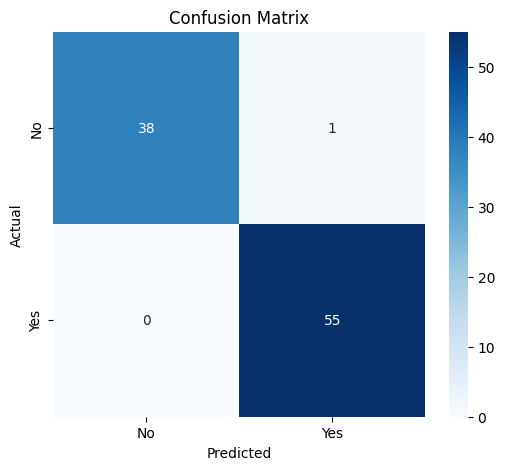

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_working.classes_, yticklabels=le_working.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC and Precision-Recall Curves
plt.figure(figsize=(15, 5))

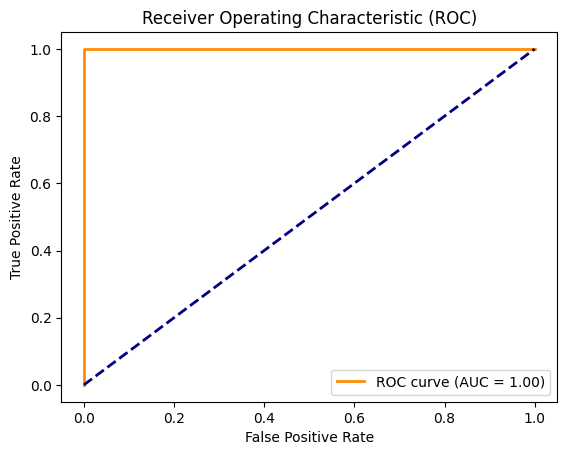

In [13]:
# ROC Curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

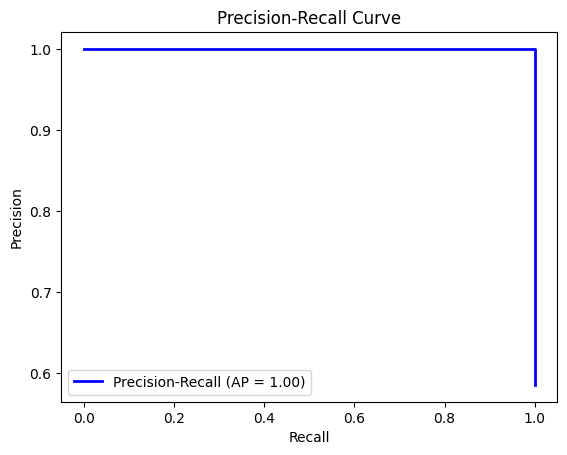

In [14]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_prob)
average_precision = average_precision_score(y_true, y_prob)
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

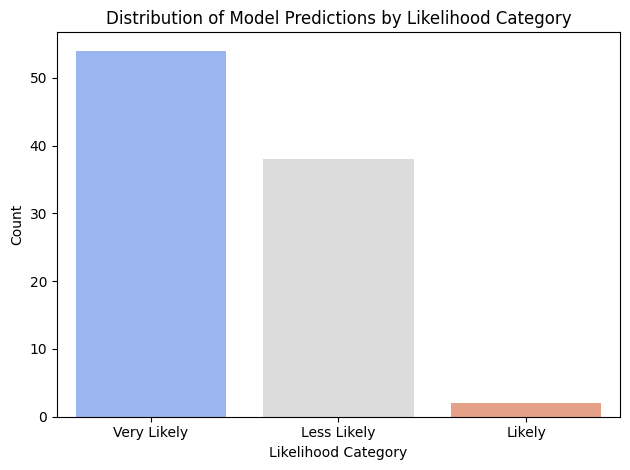

In [15]:
# Likelihood Category Distribution
category_counts = pd.Series(y_categorized).value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values, palette="coolwarm")
plt.xlabel("Likelihood Category")
plt.ylabel("Count")
plt.title("Distribution of Model Predictions by Likelihood Category")

plt.tight_layout()
plt.show()

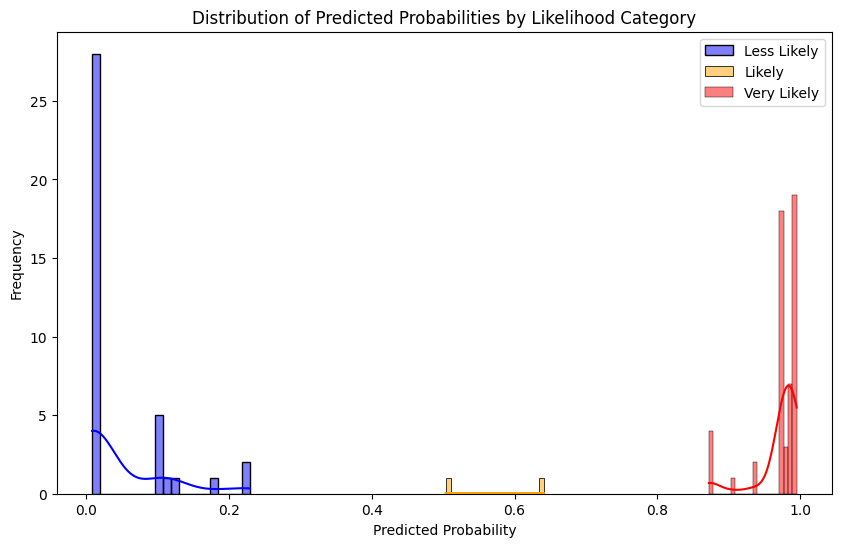

In [16]:
# Histogram of Predicted Probabilities by Category
category_colors = {"Less Likely": "blue", "Likely": "orange", "Very Likely": "red"}
plt.figure(figsize=(10, 6))
for category, color in category_colors.items():
    sns.histplot(y_prob[np.array(y_categorized) == category], bins=20, color=color, label=category, kde=True)

plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities by Likelihood Category")
plt.legend()
plt.show()

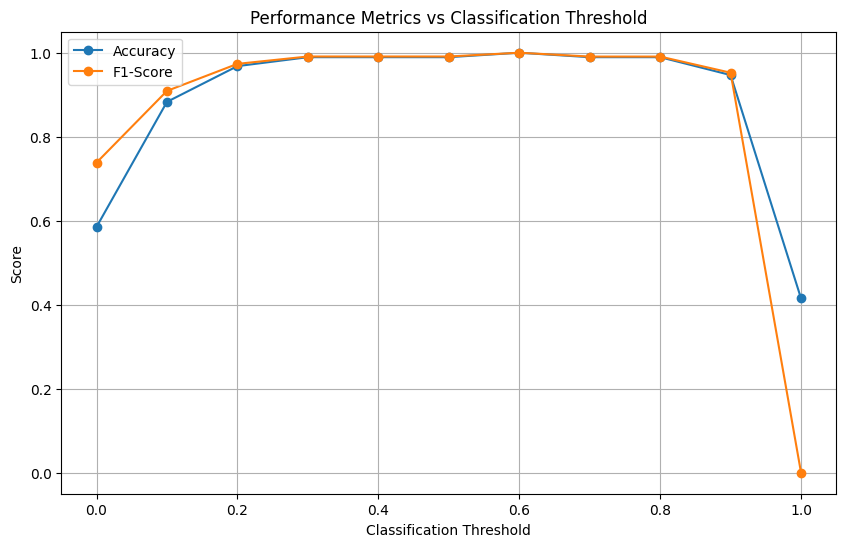

In [17]:
# Threshold Analysis
thresholds = np.arange(0, 1.1, 0.1)
accuracies, f1_scores = [], []

for threshold in thresholds:
    y_pred_threshold = (y_prob >= threshold).astype(int)
    accuracies.append(accuracy_score(y_true, y_pred_threshold))
    f1_scores.append(f1_score(y_true, y_pred_threshold))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label='Accuracy', marker='o')
plt.plot(thresholds, f1_scores, label='F1-Score', marker='o')
plt.xlabel('Classification Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics vs Classification Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [19]:


joblib.dump(model, "course_guidance_model.model")

['course_guidance_model.model']